### 필요한 패키지 import

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### 1. 데이터 처리와 분류

- 라벨 데이터 처리하기
- sklearn의 train_test_split함수를 이용하여 train, test 분리

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# target_list 각각의 요소에 대해 인덱스를 부여하고, 각 요소를 인덱스로 변환
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for index, label in enumerate(label_value):
    new_label_value[label] = index

label_value = new_label_value

# speech_data의 라벨 값들을 label_value에 담긴 대응하는 인덱스 값으로 변환
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])

label_data = np.array(temp)

# 학습 데이터셋과 테스트 데이터셋으로 데이터셋 분리
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

### 2. 학습을 위한 하이퍼파라미터 설정

In [3]:
batch_size = 32
max_epochs = 10

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

### 3. 데이터셋 구성

- tf.data.Dataset을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.   
  tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.   
    del speech_data   
    del spec_data

In [4]:
# waveform 형식을 spectogram 형식으로 변환하는 함수
def wav2spec(wav):
    spec_data =[]
    for data in wav:
        temp_data = np.abs(librosa.stft(data, n_fft=258))
        spec_data.append(temp_data)
    return np.array(spec_data)

In [5]:
# train_wav를 spectogram 형식으로 변환
train_spec = wav2spec(train_wav)

In [6]:
# test_wav를 spectogram 형식으로 변환
test_spec = wav2spec(test_wav)

In [7]:
del speech_data

In [8]:
one_hot_label = lambda x, y : (x, tf.one_hot(y, depth=12))

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)


test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [9]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
- loss, accuracy를 그래프로 표현

In [10]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1420/1423 [============================>.] - ETA: 0s - loss: 1.3831 - accuracy: 0.5273
Epoch 00001: val_loss improved from inf to 0.79657, saving model to /home/aiffel/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 17s 12ms/step - loss: 1.3824 - accuracy: 0.5276 - val_loss: 0.7966 - val_accuracy: 0.7328
Epoch 2/10
1418/1423 [============================>.] - ETA: 0s - loss: 0.6279 - accuracy: 0.7899
Epoch 00002: val_loss improved from 0.79657 to 0.49783, saving model to /home/aiffel/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 17s 12ms/step - loss: 0.6274 - accuracy: 0.7900 - val_loss: 0.4978 - val_accuracy: 0.8350
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8544
Epoch 00003: val_loss improved from 0.49783 to 0.40282, saving model to /home/aiffel/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 16s 12ms/step - loss: 0.43

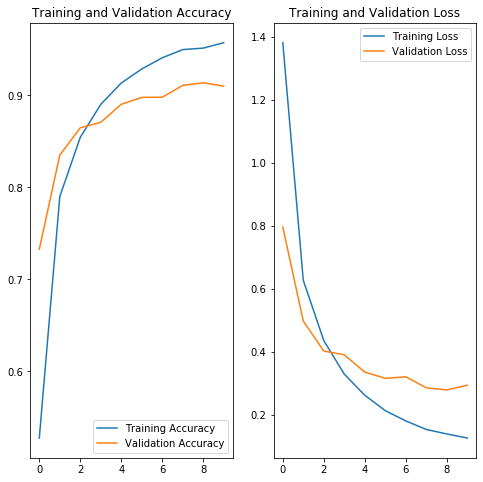

In [11]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6. Test dataset을 이용해서 모델의 성능을 평가
- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [12]:
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)

159/159 [==============================] - 14s 91ms/step - loss: 0.2790 - accuracy: 0.9137


In [13]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: right(Correct!)


### Conv2D layer 사용 모델

In [8]:
train_spec_4d = train_spec.reshape(-1, 130, 126, 1)
test_spec_4d = test_spec.reshape(-1, 130, 126, 1)

one_hot_label = lambda x, y : (x, tf.one_hot(y, depth=12))

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec_4d, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)


test_dataset = tf.data.Dataset.from_tensor_slices((test_spec_4d, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [9]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [10]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_conv2d'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.7608
Epoch 00001: val_loss improved from inf to 0.28408, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_conv2d
1423/1423 [==============================] - 204s 143ms/step - loss: 0.7162 - accuracy: 0.7608 - val_loss: 0.2841 - val_accuracy: 0.9161
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9270
Epoch 00002: val_loss improved from 0.28408 to 0.25497, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_conv2d
1423/1423 [==============================] - 205s 144ms/step - loss: 0.2338 - accuracy: 0.9270 - val_loss: 0.2550 - val_accuracy: 0.9237
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9483
Epoch 00003: val_loss improved from 0.25497 to 0.17594, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_conv2d
1423/1423 [==============================] - 2

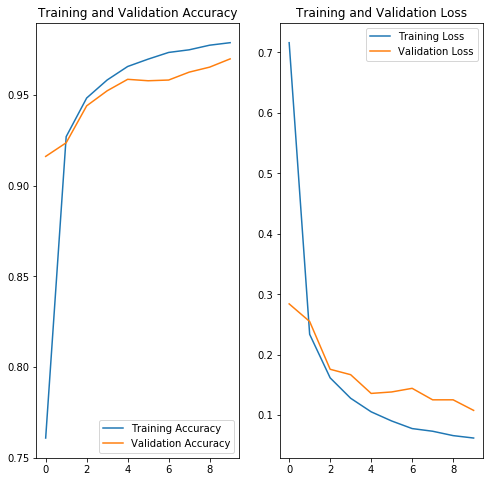

In [11]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)

159/159 [==============================] - 22s 139ms/step - loss: 0.1078 - accuracy: 0.9700


In [13]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: right(Correct!)


### Skip Connection을 적용한 Model

In [14]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [16]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 1.5132 - accuracy: 0.4895
Epoch 00001: val_loss improved from inf to 0.93893, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 16s 11ms/step - loss: 1.5131 - accuracy: 0.4895 - val_loss: 0.9389 - val_accuracy: 0.6806
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.7612
Epoch 00002: val_loss improved from 0.93893 to 0.55071, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 17s 12ms/step - loss: 0.7222 - accuracy: 0.7612 - val_loss: 0.5507 - val_accuracy: 0.8198
Epoch 3/10
1420/1423 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.8419
Epoch 00003: val_loss improved from 0.55071 to 0.46513, saving model to /home/aiffel/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 16s 11ms/st

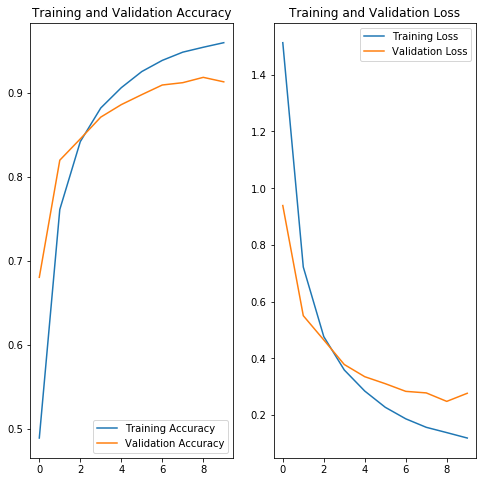

In [17]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

159/159 [==============================] - 4s 25ms/step - loss: 0.2485 - accuracy: 0.9182


In [19]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: yes(Correct!)


### 회고

**목표**

wav 형식의 데이터를 librosa 라이브러리를 활용해 spectrogram으로 변환해 그 데이터에 대해 모델을 생성한다.

**고민했던 점**

1. 작성한 코드의 순서상 모델을 구성한 후 학습을 진행하려 할 때, 계속해서 커널이 종료되는 현상이 있었다. 알고보니 메모리가 부족해서 발생하는 현상이었다. speech_data는 분할한 후에는 더 이상 사용하지 않을 데이터기 때문에 del speech_data로 메모리에서 해제해줬더니 모델 학습이 진행됐다.

2. librosa 라이브러리를 활용해서 wav 형식을 spectrogram으로 변환할 수 있었지만, spectrogram을 다시 wav 형식으로 변환하는 것은 생각보다 어려웠다. 변환에 성공하더라도 원래의 소리가 그대로 복원되지 않아서 찾아보니, spectrogram과 mel spectrogram이 있는데, wav과 mel spectrogram은 쉽게 상호 변환이 가능하도록 라이브러리에서 관련 기능을 제공했다.

3. conv1d 레이어와 conv2d 레이어의 차이는 필터가 1차원으로만 움직이는지, 2차원으로 움직이는지의 차이라는 걸 알게 됐다. conv1d 레이어의 입력 데이터 차원은 3차원이고, conv2d 레이어의 입력 데이터 차원은 4차원인 것도 필터의 움직임이 한 차원 더 높기 때문이 아닐까 생각한다. train_spec과 test_spec 데이터를 한 차원씩 높여서 reshape한 후 conv2d로 학습을 진행해보면, 학습 시간이 훨씬 더 걸렸다. 두 모델의 summary를 보면 차이점은 conv1d 레이어 모델은 output shape (None, 130, 126)에서 126이 의미있게 활용되는 것 같지 않은 것 같다. 또한 파라미터의 수가 거의 10배가 차이난다. 파라미터가 어떻게 정해지는지 필터가 어떻게 적용되는 것인지 더 알아봐야 할 것 같다.